In [1]:
import sqlite3
import re
from collections import Counter

import pandas
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from numpy import zeros, column_stack

# Agglomerative clustering seems to work better with this data vs. k-means, 
# perhaps due to the small number of queries.
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

nlp = spacy.load("en_core_web_lg")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [2]:
connection = sqlite3.connect("b2b_google_analytics.db")

In [3]:
# GloVe, unlike Word2Vec, makes use of words such as "the", "a", etc.
# I don't want them to influence the clusters.
# Note that, on a larger data set, we may not want to remove all of these (slugs could be in the news :) ).
stopwords = STOP_WORDS.union(["https", "//apnews.com", "s", "ap", "news", "was", "are", "aptopix", "u0000",
                              "byline", "slug", "related", "article", "click", "copy", "topics", "photo"])

In [4]:
df = pandas.read_sql(("SELECT distinct query FROM keyword_search k"), connection)
df["ignore"] = df["query"].apply(lambda x : ("persons.code:" in x or "subjects.code:" in x
                                             or "places.code:" in x))
df = df[df["ignore"] == False]
del df["ignore"]

df["query"] = df["query"].apply(str.lower)
df["query"] = df["query"].apply(lambda x : re.sub(r'["\\\-:]+', " ", x).strip())
df["query"] = df["query"].apply(lambda x : ("joe biden" if x == "biden" else
                                           ("donald trump" if x == "trump" else x)))

df = df.drop_duplicates()
df

,query
0,joe biden
1,donald trump
2,missouri
3,missouri parson
4,cori bush missouri
...,...
10633,first presbyterian church stamford
10634,vote trump
10636,"alexander, kwame"
10637,dan swanson


In [5]:
def get_vector(x):
    vector = zeros(300)
    for token in nlp(x):
        if token.text not in stopwords and token.has_vector:
            vector = vector + token.vector
    return vector

In [6]:
df["vector"] = df["query"].apply(get_vector)

In [7]:
# from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for (i, merge) in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

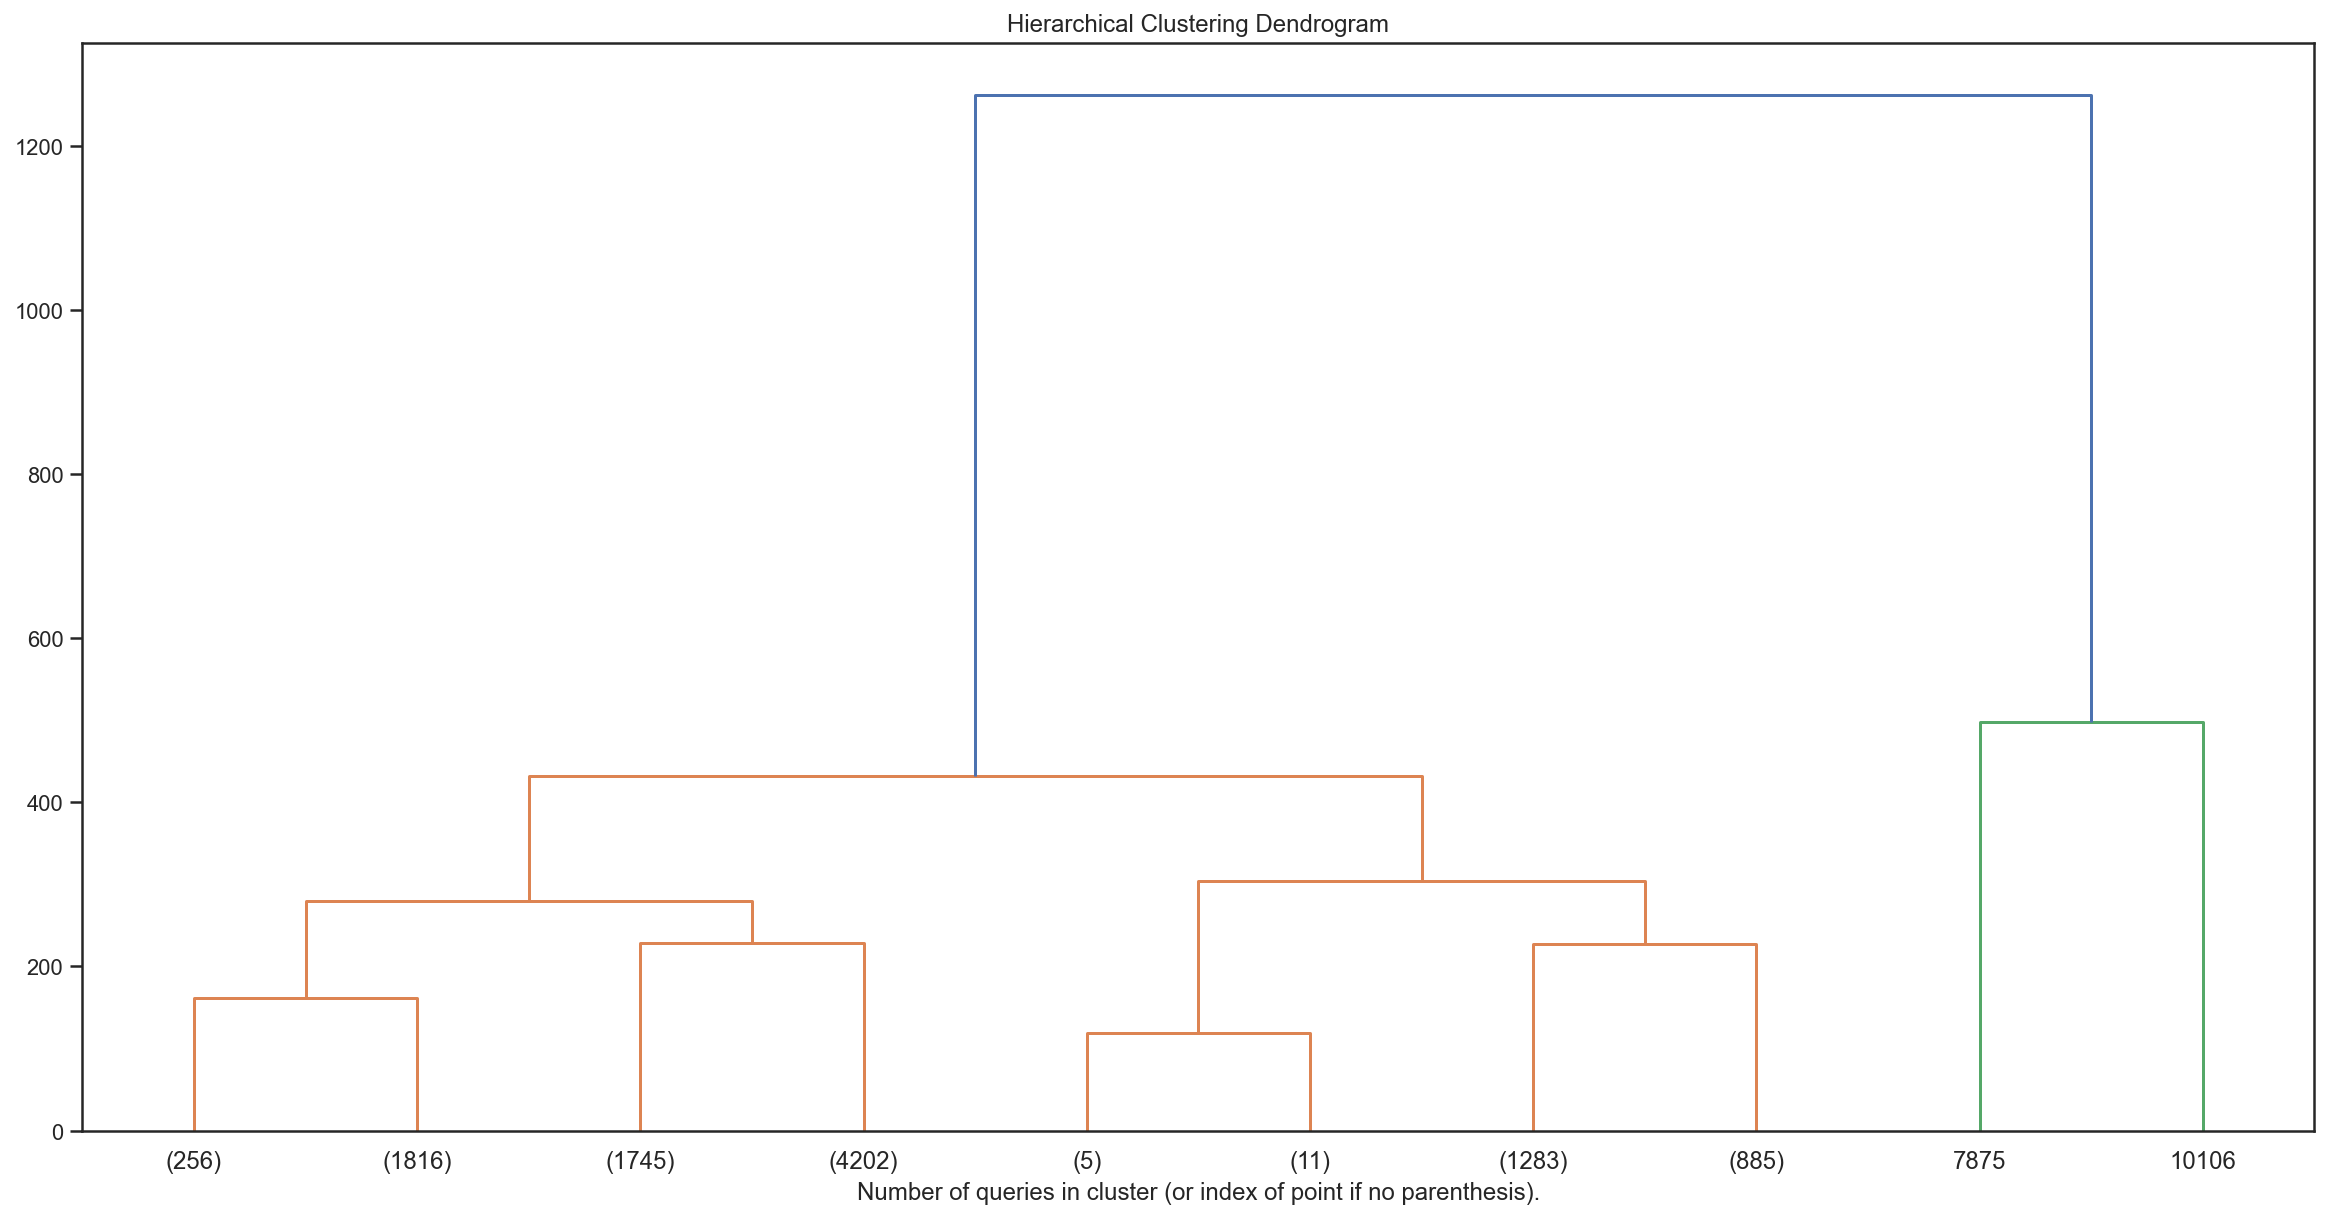

In [8]:
# Setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(list(df["vector"]))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the top p levels of the dendrogram.
# Values in parentheses show the number of queries in that cluster.
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of queries in cluster (or index of point if no parenthesis).")
plt.show()

In [9]:
agg = AgglomerativeClustering(n_clusters=8).fit(list(df["vector"]))
df["cluster"] = agg.labels_

In [10]:
for i in range(0, 8):
    cluster_tokens = []
    for query in list(df[df["cluster"] == i]["query"]):
        cluster_tokens += [t.text for t in nlp(query) if 
                           t.tag_[0] in ["N", "V", "R", "J"] and len(t.text) > 1 and t.text not in stopwords]
    token_counts = Counter(cluster_tokens)
    print(i, sorted(token_counts.items(), key=lambda x : x[1], reverse=True)[0:10])
    print()

0 [('new', 104), ('football', 58), ('york', 58), ('state', 57), ('county', 44), ('carolina', 44), ('house', 38), ('nov', 36), ('north', 35), ('trump', 33)]

1 [('trump', 227), ('virus', 117), ('coronavirus', 71), ('outbreak', 65), ('covid', 64), ('digest', 55), ('nfl', 54), ('donald', 53), ('house', 48), ('category', 43)]

2 [('biden', 218), ('joe', 83), ('trump', 44), ('john', 32), ('mike', 30), ('harris', 25), ('smith', 24), ('tom', 21), ('jones', 21), ('election', 20)]

3 [('election', 580), ('voting', 173), ('vote', 89), ('senate', 74), ('day', 53), ('ballot', 50), ('trump', 50), ('elections', 45), ('voters', 40), ('u.s', 33)]

4 [('election', 7), ('europe', 5), ('germany', 5), ('trump', 4), ('monday', 4), ('tuesday', 4), ('president', 3), ('donald', 3), ('coronavirus', 3), ('washington', 3)]

5 [('girl', 5), ('rubble', 5), ('turkish', 3), ('quake', 3), ('turkey', 3), ('pulled', 3), ('building', 3), ('ayda', 3), ('told', 3), ('said', 3)]

6 [('glf', 12), ('bkc', 10), ('bbo', 9), ('